In [440]:
#!/usr/bin/env python3 -u
# Copyright (c) 2017-present, Facebook, Inc.
# All rights reserved.
#
# This source code is licensed under the license found in the LICENSE file in
# the root directory of this source tree.
from __future__ import print_function

import argparse
import csv
import os

import numpy as np
import torch
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import models
from utils import progress_bar
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from tqdm import tqdm

# parser = argparse.ArgumentParser(description='PyTorch CIFAR10 Training')
# parser.add_argument('--lr', default=0.1, type=float, help='learning rate')
# parser.add_argument('--resume', '-r', action='store_true',
#                     help='resume from checkpoint')
# parser.add_argument('--model', default="ResNet18", type=str,
#                     help='model type (default: ResNet18)')
# parser.add_argument('--name', default='0', type=str, help='name of run')
# parser.add_argument('--seed', default=0, type=int, help='random seed')
# parser.add_argument('--batch-size', default=128, type=int, help='batch size')
# parser.add_argument('--epoch', default=200, type=int,
#                     help='total epochs to run')
# parser.add_argument('--no-augment', dest='augment', action='store_false',
#                     help='use standard augmentation (default: True)')
# parser.add_argument('--decay', default=1e-4, type=float, help='weight decay')
# parser.add_argument('--alpha', default=1., type=float,
#                     help='mixup interpolation coefficient (default: 1)')
# args = parser.parse_args()

params = {
    "lr": .01,
    "resume": False,
    "model": "ResNet18",
    "name": "mixup-128-AdvsTrain-Eps0.45",
    "seed": 10,
    "batch_size": 128,
    "decay": 1e-4, 
    "augment": True,
    "epoch": 200,
#     "no_augment": False,
    "alpha": 1.,
}

In [441]:



use_cuda = torch.cuda.is_available()

best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

if params["seed"] != 0:
    torch.manual_seed(params["seed"])

# Data
print('==> Preparing data..')
if params["augment"]:
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2023, 0.1994, 0.2010)),
    ])
else:
    print("no augmentation")
    transform_train = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2023, 0.1994, 0.2010)),
    ])


transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = datasets.CIFAR10(root='./data', train=True, download=False,
                            transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=params["batch_size"],
                                          shuffle=True, num_workers=8)

testset = datasets.CIFAR10(root='./data', train=False, download=False,
                           transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                         shuffle=False, num_workers=8)

==> Preparing data..


In [442]:
# Model
if params["resume"]:
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load('./checkpoint/ckpt.t7' + params["name"] + '_'
                            + str(params["seed"]), map_location='cpu')
    
    net = checkpoint['net']
    best_acc = checkpoint['acc']
    start_epoch = checkpoint['epoch'] + 1
    rng_state = checkpoint['rng_state']
    torch.set_rng_state(rng_state)
else:
    print('==> Building model..')
    net = models.__dict__[params["model"]]()

if not os.path.isdir('results'):
    os.mkdir('results')
logname = ('results/log_' + net.__class__.__name__ + '_' + params["name"] + '_'
           + str(params["seed"]) + '.csv')

if use_cuda:
    net = torch.nn.DataParallel(net)
    net.to(f'cuda:{net.device_ids[0]}')
    print(torch.cuda.device_count())
    cudnn.benchmark = True
    print('Using CUDA..')

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=params["lr"], momentum=0.9,
                      weight_decay=params["decay"])

==> Building model..
3
Using CUDA..


In [407]:
a = torch.tensor([1,2,3,4])
b = a[[3,2,1,0]]
b[0] = 12
b

tensor([12,  3,  2,  1])

In [443]:
def mixup_data(x, y, alpha=1.0, use_cuda=True, advs_train=False, epsilon=.35):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)
    

    
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    
    
    
    if advs_train:
        
        x_b = x[index, :]
        
        x_b.requires_grad_(True)
        x.requires_grad_(True)
        
        out_a = net(x)
        loss_a = criterion(out_a, y_a)
        optimizer.zero_grad()
        loss_a.backward()
        
        err = torch.zeros_like(x)
        with torch.no_grad():
            err += epsilon * lam * x.grad.sign()

        out_b = net(x_b)
        loss_b = criterion(out_b, y_b)
        optimizer.zero_grad()
        loss_b.backward()
        
        with torch.no_grad():
            err += epsilon * (1 - lam) * x_b.grad.sign()
            
        mixed_x += err
        
        
        

    return mixed_x, y_a, y_b, lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)


def train_mixup(epoch, erm=False, advs_train=False, epsilon=.35):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    reg_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        
        if erm:
            inputs, targets_a, targets_b, lam = mixup_data(inputs, targets,
                                                           alpha=0, use_cuda=use_cuda, advs_train=advs_train)            
        else:
            inputs, targets_a, targets_b, lam = mixup_data(inputs, targets,
                                                           params["alpha"], use_cuda, 
                                                           advs_train=advs_train, epsilon=epsilon)
        inputs, targets_a, targets_b = map(Variable, (inputs,
                                                      targets_a, targets_b))
        outputs = net(inputs)
        loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (lam * predicted.eq(targets_a.data).cpu().sum().float()
                    + (1 - lam) * predicted.eq(targets_b.data).cpu().sum().float())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        progress_bar(batch_idx, len(trainloader),
                     'Loss: %.3f | Reg: %.5f | Acc: %.3f%% (%d/%d)'
                     % (train_loss/(batch_idx+1), reg_loss/(batch_idx+1),
                        100.*correct/total, correct, total))
    return (train_loss/batch_idx, reg_loss/batch_idx, 100.*correct/total)




def fgsm(x, y, eps):
    
        x.requires_grad_(True)
        out = net(x)
        loss = criterion(out, y)
        optimizer.zero_grad()
        loss.backward()
        
        with torch.no_grad():
            err = eps * lam * x.grad.sign()    
            x_advs = x + err


def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(testloader):
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        inputs, targets = Variable(inputs, volatile=True), Variable(targets)
        outputs = net(inputs)
        loss = criterion(outputs, targets)

        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()

        progress_bar(batch_idx, len(testloader),
                     'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                     % (test_loss/(batch_idx+1), 100.*correct/total,
                        correct, total))
    acc = 100.*correct/total
    if acc > best_acc:
        best_acc = acc
        checkpoint(acc, epoch)

        
    return (test_loss/batch_idx, 100.*correct/total)


def checkpoint(acc, epoch):
    # Save checkpoint.
    print('Saving..')
    state = {
        'net': net,
        'acc': acc,
        'epoch': epoch,
        'rng_state': torch.get_rng_state()
    }
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/ckpt.t7' + params["name"] + '_'
               + str(params["seed"]))


def adjust_learning_rate(optimizer, epoch):
    """decrease the learning rate at 100 and 150 epoch"""
    lr = params["lr"]
    if epoch >= 100:
        lr /= 10
    if epoch >= 150:
        lr /= 10
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [444]:
if not os.path.exists(logname):
    with open(logname, 'w') as logfile:
        logwriter = csv.writer(logfile, delimiter=',')
        logwriter.writerow(['epoch', 'train loss', 'reg loss', 'train acc',
                            'test loss', 'test acc'])

for epoch in range(start_epoch, params["epoch"]):
    train_loss, reg_loss, train_acc = train(epoch, erm=False, advs_train=True, epsilon=.45)
    test_loss, test_acc = test(epoch)
    adjust_learning_rate(optimizer, epoch)
    with open(logname, 'a') as logfile:
        logwriter = csv.writer(logfile, delimiter=',')
        logwriter.writerow([epoch, train_loss, reg_loss, train_acc, test_loss,
                            test_acc])


Epoch: 0
 [=====================================================================================>]  Step: 155ms | Tot: 58s482ms | Loss: 2.304 | Reg: 0.00000 | Acc: 11.587% (5793/50000 391/391 


<ipython-input-443-a2a30524e926>:105: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  inputs, targets = Variable(inputs, volatile=True), Variable(targets)


 [=====================================================================================>]  Step: 34ms | Tot: 3s636ms | Loss: 2.142 | Acc: 25.000% (2500/10000 100/100 
Saving..

Epoch: 1
 [=====================================================================================>]  Step: 155ms | Tot: 58s754ms | Loss: 2.270 | Reg: 0.00000 | Acc: 13.578% (6789/50000 391/391 
 [=====================================================================================>]  Step: 37ms | Tot: 3s614ms | Loss: 2.108 | Acc: 25.360% (2536/10000 100/100 
Saving..

Epoch: 2
 [=====================================================================================>]  Step: 148ms | Tot: 58s738ms | Loss: 2.252 | Reg: 0.00000 | Acc: 15.037% (7518/50000 391/391 
 [=====================================================================================>]  Step: 37ms | Tot: 3s595ms | Loss: 2.052 | Acc: 24.080% (2408/10000 100/100 

Epoch: 3
 [=================================================================================

 [=====================================================================================>]  Step: 41ms | Tot: 3s649ms | Loss: 1.380 | Acc: 52.320% (5232/1000 99/100 ]  Step: 38ms | Tot: 994ms | Loss: 1.396 | Acc: 52.379% (1519/2900 29/100 31/100 ................]  Step: 45ms | Tot: 1s552ms | Loss: 1.388 | Acc: 52.886% (2327/4400 44/100 53/100 ...................]  Step: 33ms | Tot: 2s132ms | Loss: 1.392 | Acc: 52.583% (3155/6000 60/100 ....]  Step: 33ms | Tot: 2s202ms | Loss: 1.387 | Acc: 52.629% (3263/6200 62/100 .....]  Step: 33ms | Tot: 2s235ms | Loss: 1.387 | Acc: 52.587% (3313/6300 63/100 =================================>..............................]  Step: 35ms | Tot: 2s335ms | Loss: 1.384 | Acc: 52.545% (3468/6600 66/100 ======================>.............]  Step: 41ms | Tot: 3s44ms | Loss: 1.381 | Acc: 52.494% (4462/8500 85/100 ...]  Step: 39ms | Tot: 3s83ms | Loss: 1.380 | Acc: 52.500% (4515/8600 86/100 .......]  Step: 42ms | Tot: 3s204ms | Loss: 1.381 | Acc: 52.404% (4664/

 [=====================================================================================>]  Step: 34ms | Tot: 3s635ms | Loss: 1.032 | Acc: 65.830% (6583/10000 100/100 

Epoch: 25
 [=====================================================================================>]  Step: 151ms | Tot: 59s49ms | Loss: 1.222 | Reg: 0.00000 | Acc: 63.711% (31855/50000 391/391  
 [=====================================================================================>]  Step: 39ms | Tot: 3s870ms | Loss: 0.997 | Acc: 67.410% (6741/10000 100/100 

Epoch: 26
 [=====================================================================================>]  Step: 149ms | Tot: 59s51ms | Loss: 1.197 | Reg: 0.00000 | Acc: 64.907% (32453/50000 391/391  
 [=====================================================================================>]  Step: 38ms | Tot: 3s643ms | Loss: 0.886 | Acc: 70.740% (7074/10000 100/100 
Saving..

Epoch: 27
 [=====================================================================================

 [=====================================================================================>]  Step: 151ms | Tot: 58s476ms | Loss: 1.139 | Reg: 0.00000 | Acc: 66.829% (33414/50000 391/391 
 [=====================================================================================>]  Step: 35ms | Tot: 3s599ms | Loss: 0.783 | Acc: 75.440% (7544/10000 100/100 
Saving..

Epoch: 46
 [=====================================================================================>]  Step: 150ms | Tot: 58s738ms | Loss: 1.116 | Reg: 0.00000 | Acc: 67.703% (33851/50000 391/391 
 [=====================================================================================>]  Step: 36ms | Tot: 3s669ms | Loss: 0.768 | Acc: 75.790% (7579/10000 100/100 
Saving..

Epoch: 47
 [=====================================================================================>]  Step: 168ms | Tot: 1m45ms | Loss: 1.131 | Reg: 0.00000 | Acc: 66.915% (33457/50000 391/391 1 
 [=====================================================================

 [=====================================================================================>]  Step: 146ms | Tot: 58s843ms | Loss: 1.087 | Reg: 0.00000 | Acc: 68.283% (34141/50000 391/391 
 [=====================================================================================>]  Step: 37ms | Tot: 3s661ms | Loss: 0.658 | Acc: 79.990% (7999/10000 100/100 

Epoch: 59
 [=====================================================================================>]  Step: 152ms | Tot: 58s793ms | Loss: 1.083 | Reg: 0.00000 | Acc: 68.716% (34357/50000 391/391 
 [=====================================================================================>]  Step: 38ms | Tot: 3s593ms | Loss: 0.738 | Acc: 76.710% (7671/10000 100/100 ................................]  Step: 38ms | Tot: 439ms | Loss: 0.713 | Acc: 78.429% (1098/1400 14/100 75/100 

Epoch: 60
 [=====================================================================================>]  Step: 160ms | Tot: 1m636ms | Loss: 1.099 | Reg: 0.00000 | Acc: 67.922%

 [=====================================================================================>]  Step: 142ms | Tot: 1m703ms | Loss: 1.064 | Reg: 0.00000 | Acc: 69.159% (34579/50000 391/391  
 [=====================================================================================>]  Step: 32ms | Tot: 3s601ms | Loss: 0.663 | Acc: 80.090% (8009/10000 100/100 ..]  Step: 38ms | Tot: 679ms | Loss: 0.675 | Acc: 79.700% (1594/2000 20/100 33/100 34/100 ...................................................]  Step: 47ms | Tot: 1s408ms | Loss: 0.666 | Acc: 79.923% (3117/3900 39/10 40/100 ==========================>.............................................]  Step: 32ms | Tot: 1s717ms | Loss: 0.664 | Acc: 80.062% (3843/4800 48/10 50/100 =============================================>........................................]  Step: 35ms | Tot: 1s915ms | Loss: 0.661 | Acc: 80.111% (4326/5400 54/100 ..............................]  Step: 30ms | Tot: 1s946ms | Loss: 0.660 | Acc: 80.145% (4408/5500 55/100 ....

 [=====================================================================================>]  Step: 36ms | Tot: 3s616ms | Loss: 0.649 | Acc: 80.810% (8081/10000 100/100 

Epoch: 86
 [=====================================================================================>]  Step: 149ms | Tot: 58s750ms | Loss: 1.043 | Reg: 0.00000 | Acc: 69.932% (34965/50000 391/391 
 [=====================================================================================>]  Step: 37ms | Tot: 3s789ms | Loss: 0.673 | Acc: 79.550% (7955/10000 100/100 ...................................]  Step: 38ms | Tot: 2s216ms | Loss: 0.673 | Acc: 79.982% (4559/5700 57/100 

Epoch: 87
 [=====================================================================================>]  Step: 153ms | Tot: 58s620ms | Loss: 1.004 | Reg: 0.00000 | Acc: 71.391% (35695/50000 391/391 
 [=====================================================================================>]  Step: 36ms | Tot: 3s606ms | Loss: 0.679 | Acc: 79.850% (7985/10000 100/1

 [=====================================================================================>]  Step: 35ms | Tot: 3s528ms | Loss: 0.613 | Acc: 82.520% (8252/10000 100/100 ==========>..........................................................................]  Step: 37ms | Tot: 438ms | Loss: 0.609 | Acc: 82.857% (1160/1400 14/100 

Epoch: 107
 [=====================================================================================>]  Step: 152ms | Tot: 58s836ms | Loss: 0.977 | Reg: 0.00000 | Acc: 71.789% (35894/50000 391/391 
 [=====================================================================================>]  Step: 36ms | Tot: 3s893ms | Loss: 0.606 | Acc: 81.860% (8186/10000 100/100   Step: 41ms | Tot: 1s605ms | Loss: 0.614 | Acc: 81.477% (3585/4400 44/100 ........]  Step: 40ms | Tot: 1s682ms | Loss: 0.608 | Acc: 81.652% (3756/4600 46/100 

Epoch: 108
 [=====================================================================================>]  Step: 146ms | Tot: 58s525ms | Loss: 0.940 | Reg:

 [=====================================================================================>]  Step: 38ms | Tot: 3s658ms | Loss: 0.635 | Acc: 81.690% (8169/10000)9/100 1/10 94/100 100/100 

Epoch: 120
 [=====================================================================================>]  Step: 151ms | Tot: 1m1s | Loss: 0.963 | Reg: 0.00000 | Acc: 71.972% (35986/50000 391/391 91  
 [=====================================================================================>]  Step: 39ms | Tot: 3s700ms | Loss: 0.600 | Acc: 82.910% (8291/10000 100/100 tep: 42ms | Tot: 415ms | Loss: 0.595 | Acc: 82.500% (990/1200 12/100 .........]  Step: 43ms | Tot: 3s149ms | Loss: 0.603 | Acc: 82.756% (7117/8600 86/100 ========>..]  Step: 38ms | Tot: 3s631ms | Loss: 0.601 | Acc: 82.888% (8123/9800 98/100 

Epoch: 121
 [=====================================================================================>]  Step: 147ms | Tot: 59s547ms | Loss: 0.944 | Reg: 0.00000 | Acc: 72.869% (36434/50000 391/391 
 [===========

 [=====================================================================================>]  Step: 35ms | Tot: 3s654ms | Loss: 0.596 | Acc: 82.520% (8252/10000 100/100 

Epoch: 140
 [=====================================================================================>]  Step: 155ms | Tot: 1m409ms | Loss: 0.963 | Reg: 0.00000 | Acc: 71.668% (35833/50000 391/391  
 [=====================================================================================>]  Step: 40ms | Tot: 3s722ms | Loss: 0.587 | Acc: 83.470% (8347/10000 100/100 100 

Epoch: 141
 [=====================================================================================>]  Step: 154ms | Tot: 1m425ms | Loss: 0.972 | Reg: 0.00000 | Acc: 71.292% (35646/50000 391/391  
 [=====================================================================================>]  Step: 36ms | Tot: 3s697ms | Loss: 0.580 | Acc: 83.840% (8384/10000 100/100 100 
Saving..

Epoch: 142
 [==========================================================================

 [=====================================================================================>]  Step: 37ms | Tot: 3s546ms | Loss: 0.584 | Acc: 83.690% (8369/10000 100/100 0/100 

Epoch: 160
 [=====================================================================================>]  Step: 152ms | Tot: 57s956ms | Loss: 0.896 | Reg: 0.00000 | Acc: 74.356% (37177/50000 391/391 
 [=====================================================================================>]  Step: 37ms | Tot: 3s537ms | Loss: 0.576 | Acc: 83.890% (8389/10000 100/100 ...............................................................................]  Step: 38ms | Tot: 228ms | Loss: 0.562 | Acc: 85.250% (682/800 8/10 10/100 ]  Step: 41ms | Tot: 488ms | Loss: 0.567 | Acc: 84.938% (1359/1600 16/100 

Epoch: 161
 [=====================================================================================>]  Step: 151ms | Tot: 58s241ms | Loss: 0.917 | Reg: 0.00000 | Acc: 73.533% (36766/50000 391/391 
 [==================================

 [=====================================================================================>]  Step: 35ms | Tot: 3s705ms | Loss: 0.594 | Acc: 83.320% (8332/10000 100/100 ...............................]  Step: 37ms | Tot: 808ms | Loss: 0.585 | Acc: 83.913% (1930/2300 23/100 37/10 38/100 41/100 ======>.]  Step: 38ms | Tot: 3s670ms | Loss: 0.594 | Acc: 83.313% (8248/9900 99/100 

Epoch: 176
 [=====================================================================================>]  Step: 370ms | Tot: 1m443ms | Loss: 0.916 | Reg: 0.00000 | Acc: 73.886% (36943/50000 391/391  
 [=====================================================================================>]  Step: 35ms | Tot: 3s680ms | Loss: 0.598 | Acc: 84.070% (8407/10000 100/100 .....................................................]  Step: 42ms | Tot: 1s281ms | Loss: 0.603 | Acc: 83.914% (2937/3500 35/100 ................]  Step: 40ms | Tot: 2s502ms | Loss: 0.599 | Acc: 83.985% (5711/6800 68/100 74/100 =============================>...

 [=====================================================================================>]  Step: 136ms | Tot: 1m407ms | Loss: 0.923 | Reg: 0.00000 | Acc: 73.267% (36633/50000 391/391  
 [=====================================================================================>]  Step: 37ms | Tot: 3s683ms | Loss: 0.607 | Acc: 82.150% (8215/10000 100/100 .................................]  Step: 31ms | Tot: 296ms | Loss: 0.588 | Acc: 83.200% (832/1000 10/100 ..................]  Step: 44ms | Tot: 581ms | Loss: 0.589 | Acc: 83.118% (1413/1700 17/100 ....................................]  Step: 40ms | Tot: 621ms | Loss: 0.593 | Acc: 82.889% (1492/1800 18/100 .......................]  Step: 40ms | Tot: 698ms | Loss: 0.593 | Acc: 83.250% (1665/2000 20/100 ]  Step: 43ms | Tot: 3s197ms | Loss: 0.609 | Acc: 81.966% (7213/8800 88/100 

Epoch: 191
 [=====================================================================================>]  Step: 160ms | Tot: 1m1s | Loss: 0.951 | Reg: 0.00000 | Acc: 72.0

 [=====================================================================================>]  Step: 31ms | Tot: 3s609ms | Loss: 0.601 | Acc: 83.350% (8335/10000 100/100 0 ...........]  Step: 38ms | Tot: 521ms | Loss: 0.588 | Acc: 84.312% (1349/1600 16/100 ..........................]  Step: 40ms | Tot: 1s962ms | Loss: 0.605 | Acc: 83.393% (4670/5600 56/100 ========>..........]  Step: 43ms | Tot: 3s197ms | Loss: 0.603 | Acc: 83.236% (7408/8900 89/100 ====================================================================>.........]  Step: 33ms | Tot: 3s231ms | Loss: 0.603 | Acc: 83.200% (7488/9000 90/100 96/100 ====================>...]  Step: 41ms | Tot: 3s500ms | Loss: 0.603 | Acc: 83.268% (8077/9700 97/10 99/100 

Epoch: 198
 [=====================================================================================>]  Step: 156ms | Tot: 1m218ms | Loss: 0.947 | Reg: 0.00000 | Acc: 72.408% (36204/50000 391/391  
 [===================================================================================

In [58]:
net.eval()
out = net(trainset[0][0].reshape(1,3,32,32))
out = torch.rand(10,10)
a,b = torch.max(out.cpu().data, 1)
print(a, b)
targ = torch.tensor([[9, 4, 2, 3, 5, 1, 2 ,3, 5, 6]])
b.eq(targ.data)

tensor([0.9240, 0.8982, 0.8241, 0.9473, 0.9188, 0.9969, 0.8158, 0.9043, 0.9454,
        0.8998]) tensor([1, 5, 2, 9, 9, 9, 3, 1, 2, 5])


tensor([[False, False,  True, False, False, False, False, False, False, False]])

In [399]:
def eval_robust(epsilon=0):
#     net.cuda()
#     net.to('cpu')
    net.to(f'cuda:{net.device_ids[0]}')
    net.eval()
    incorrect = 0
    total = 0
    
    for batch_idx, (normal_inpts, targets) in tqdm(enumerate(testloader)):
        if use_cuda:
            normal_inpts, targets = normal_inpts.cuda(), targets.cuda()
#             normal_inpts, targets = normal_inpts.to('cuda:1'), targets.to('cuda:1')
#         normal_inpts, targets = Variable(normal_inpts, volatile=True), Variable(targets)
        normal_inpts.requires_grad_(True)
        
        outputs = net(normal_inpts)
        loss = criterion(outputs, targets)
        
        optimizer.zero_grad()
        loss.backward()
        
        
        with torch.no_grad():
            advers_inp = normal_inpts + (epsilon * normal_inpts.grad.sign())
            advers_out = net(advers_inp)
#             print(advers_out.cpu().data.shape)
            normal_out = net(normal_inpts)
            _,advs_predicted = torch.max(advers_out.data, 1)
            _,normal_predicted = torch.max(normal_out.data, 1)
    

#         _, advs_predicted = torch.max(advs_predicted.data, 1)
        total += targets.size(0)
        incorrect += targets.size(0) - advs_predicted.eq(targets.data).sum()
    
    print(f'incorrects are: {incorrect} \ntotal is: {total} \nTop-1 error is {100.*incorrect/total}')
        

#     acc = 100.*correct/total
#     return (test_loss/batch_idx, 100.*correct/total)

In [449]:
eval_robust(.25)

100it [00:08, 11.42it/s]

incorrects are: 446 
total is: 10000 
Top-1 error is 4.460000038146973


In [448]:
best_acc

tensor(84.3200)

In [164]:
def imshow(img):
#     img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
#     plt.imshow(npimg)
    plt.show()

In [337]:
best_acc

tensor(94.6600)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


true labels is 1 
 adversaliral predicted is tensor([6]) 
 nomral is predictedtensor([1])


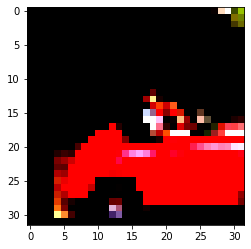

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


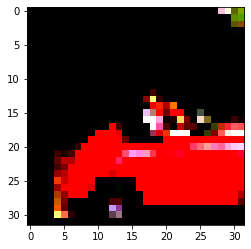

In [186]:
epsilon = .11
i = random.randint(0,100)
# i = 1


normal_inpt = trainset[i][0].reshape(1,3,32,32).cuda()
normal_inpt.requires_grad_(True)
out = net(normal_inpt)

target = torch.tensor([trainset[i][1]]).cuda()

loss = criterion(out, target)

optimizer.zero_grad()
loss.backward()

with torch.no_grad():
    advers_inp = normal_inpt + (epsilon * normal_inpt.grad.sign())
    advers_out = net(advers_inp)
    normal_out = net(normal_inpt)
    _,advs_predicted = torch.max(advers_out.cpu().data, 1)
    _,normal_predicted = torch.max(normal_out.cpu().data, 1)
    
print(f'true labels is {target.item()} \n adversaliral predicted is {advs_predicted} \n nomral is predicted{normal_predicted}')

imshow(normal_inpt.cpu().detach().squeeze())
imshow(advers_inp.cpu().detach().squeeze())

In [264]:
# advers_out = net(advers_inp) #+ (epsilon * normal_inpt.grad.sign())
# print(advers_out)
mx = 100
for j in range(1000):
    i = random.randint(0,3000)
    if torch.min(torch.min(trainset[i][0], -1)[0], -1)[0][0] < mx:
        mx = torch.min(torch.min(trainset[i][0], -1)[0], -1)[0][0]
mx

tensor(-2.4291)

In [281]:
import pandas as pd
df = pd.read_csv("results/log_ResNet_0_0.csv")
df

,epoch,train loss,reg loss,train acc,test loss,test acc
0,0,1.854828,0.0,tensor(35.1079),1.217799,tensor(57.0300)
1,1,1.580279,0.0,tensor(48.6740),0.930699,tensor(69.6800)
2,2,1.464894,0.0,tensor(54.0907),0.964110,tensor(68.2700)
3,3,1.409389,0.0,tensor(56.5027),0.768147,tensor(76.2700)
4,4,1.358588,0.0,tensor(58.5401),0.707272,tensor(78.8900)
...,...,...,...,...,...,...
195,195,0.770341,0.0,tensor(74.8484),0.297381,tensor(95.1700)
196,196,0.745491,0.0,tensor(75.9486),0.265202,tensor(95.3000)
197,197,0.749481,0.0,tensor(75.8501),0.252477,tensor(95.4300)
198,198,0.763400,0.0,tensor(75.3202),0.269733,tensor(95.2800)


In [310]:
a = torch.rand(3,4,3)
print(a)
sft = torch.nn.Softmax(-1)
print(sft(a))
sft(a).sum(-1)
# torch.exp(sft(a)).sum(-1)

tensor([[[0.9641, 0.0873, 0.3040],
         [0.6683, 0.1927, 0.6105],
         [0.8455, 0.1752, 0.4758],
         [0.6430, 0.3145, 0.5078]],

        [[0.1382, 0.6639, 0.0553],
         [0.8324, 0.5710, 0.6972],
         [0.8507, 0.6525, 0.6409],
         [0.6024, 0.1346, 0.0435]],

        [[0.5885, 0.2321, 0.8776],
         [0.2466, 0.8369, 0.2947],
         [0.8890, 0.1531, 0.4535],
         [0.0668, 0.7166, 0.5534]]])
tensor([[[0.5173, 0.2153, 0.2674],
         [0.3898, 0.2423, 0.3679],
         [0.4540, 0.2323, 0.3137],
         [0.3856, 0.2776, 0.3368]],

        [[0.2768, 0.4683, 0.2548],
         [0.3783, 0.2913, 0.3304],
         [0.3801, 0.3118, 0.3082],
         [0.4549, 0.2849, 0.2601]],

        [[0.3294, 0.2307, 0.4399],
         [0.2595, 0.4682, 0.2723],
         [0.4704, 0.2253, 0.3043],
         [0.2202, 0.4217, 0.3582]]])


tensor([[1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000]])

In [297]:
torch.log(torch.tensor([torch.exp(torch.tensor(1.))]))

tensor([1.0000])